In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit
import random as rd
from sympy import *
import tensorflow as tf
import tensorflow_quantum as tfq
import math
import re
import itertools
from numpy import linalg as LA
from scipy.stats import poisson
import time
from random import choices
from random import uniform
import pandas as pd

2023-05-09 14:45:29.343667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 14:45:29.343680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-09 14:45:29.982627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-09 14:45:29.982640: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-09 14:45:29.982650: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rafael-ThinkPad): /proc/driver/nvidia/version does not exist
2023-05-09 14:45:29.982796: I tensorflow/core/platform/cpu_fe

In [17]:
k = 5 #length of clauses
n_var = 5 #number of variables
nqubits = n_var #number of qubits in the circuit
all_vars = [i for i in range(-n_var,n_var+1)]
all_vars = [i for i in all_vars if i != 0]

## Definitions

In [18]:
r_by_k = {2 : 1, 3: 6.43, 4: 20.43, 5 : 45.7, 6: 70.21, 7: 123.2, 8: 176.54, 10: 708.92, 16: 45425.2}

def generate_instance(k: int, n: int) -> np.ndarray:
    #generate an instance of random k-SAT with n variables in the satisfiability threshold
    if not (r := r_by_k.get(k)):
        raise ValueError(f"k must be in {list(r_by_k)} (got {k})")
    
    m = poisson(r*n).rvs()
    #return np.random.choice(all_vars, size=(m, k))
    all_variables = []
    all_signs = []
    for i in range(m):
        #all_signs.append([rd.choice(l) for i in range(k)])
        all_variables.append(choices(all_vars, k = k))

    all_variables = np.array(all_variables)
    #all_signs = np.array(all_signs)
    return all_variables

In [19]:
def generate_binary_strings(bit_count):
    binary_strings = []
    
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

In [20]:
def dimacs_writer(dimacs_filename, cnf_array):
    #writes the dimacs file with the CNF
    cnf = cnf_array
    cnf_length = len(cnf)
    n_sat = len(cnf[0])
    var_num = np.max(cnf) 
    with open(dimacs_filename, "w") as f:

        f.write('c DIMACS file CNF '+str(n_sat)+'-SAT \n')
        f.write("p cnf {} {}\n".format(var_num, cnf_length))
        
        for i, clause in enumerate(cnf):
            line = clause.tolist()
            if i == cnf_length - 1:
                s = ' '.join(str(x) for x in line)+' 0'
                f.write(s)
            else: 
                s = ' '.join(str(x) for x in line)+' 0 \n'
                f.write(s)
                
class Verifier():
    #verifier from Qiskit page, takes a bit string and checks if cnf is satisfied
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [21]:
def my_gate(c, index):
    g = c * cirq.Z.on(qubits[index]) + cirq.I.on(qubits[index])
    return g

def ham_layer(diagonal, circuit, qubits, par):
    
    l = cirq.DiagonalGate(diagonal)._decompose_(qubits)
    l.pop(0)
    for j, gate in enumerate(l):

        if j % 2 == 0:
            dictn = gate._json_dict_()
            my_string = str(dictn['gate'])
            my_other_string = str(dictn['qubits'])
            number_p = re.findall("\d+\.\d+", my_string)
            res_p = [eval(i) for i in number_p]
            if '-' in my_string:
                sign = -1
            else:
                sign = 1
            
            number_q = re.findall(r'\d+', my_other_string)
            res_q = [eval(i) for i in number_q]
            kernel = sign*par*res_p[0]*np.pi
            rzgate = cirq.rz(kernel).on(qubits[res_q[1]])
            circuit.append(rzgate)
        else:
            circuit.append(gate)

def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [22]:
def circuit_from_dimacs(dimacs_file, binary_strings, nqubits, qubits, layers, parameters):
    
    with open(dimacs_file, 'r') as f:
            dimacs = f.read()
    
    unsat_list = []

    for key in binary_strings:
        guess = [bool(int(x)) for x in key][::-1]

        clause_eval_list = []
        counter = 0
        for j, line in enumerate(dimacs.split('\n')):

            line = line.strip(' 0')
            clause_eval = False

            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    #line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if j > 1:
                counter += 1
                clause_eval_list.append(clause_eval)
        unsat_clauses = counter - sum(clause_eval_list)
        unsat_list.append(unsat_clauses)

    diagonal = unsat_list
    combinations = [p for p in itertools.product([1, -1], repeat=nqubits)]

    ops_list = []
    for j, combination in enumerate(combinations):
        ops_list.append((diagonal[j]/2**nqubits)*math.prod([my_gate(combination[i], i) for i in range(nqubits)]))

    cost = np.sum(ops_list)
    cost_m = cost.matrix()
    gs_energy = np.real(min(LA.eig(cost_m)[0]))
    
    qaoa_circuit = cirq.Circuit()
    num_param = 2 * layers

    for i in range(layers):
        ham_layer(diagonal, qaoa_circuit, qubits, parameters[2 * i])
        mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

    return qaoa_circuit, cost

## Training

In [23]:
qubits = [cirq.GridQubit(0,i) for i in range(nqubits)]
valid_keys = []
dimacs_file = "data/random_cnf_BM_temp.dimacs" 
binary_strings = generate_binary_strings(nqubits)

while not valid_keys:
    #only accepts satisfiable CNFs
    inst = generate_instance(k, n_var)
    dimacs_writer(dimacs_file, inst)
    v = Verifier(dimacs_file)

    for key in binary_strings:
        if v.is_correct(key) == True:
            valid_keys.append(key)

valid_keys

['01010']

In [24]:
p = 4
parameters = symbols("q0:%d" % (2*p))
qaoa_circuit, cost = circuit_from_dimacs(dimacs_file, binary_strings, nqubits, qubits, p, parameters)
cost_m = cost.matrix()
gs_energy = np.real(min(LA.eig(cost_m)[0]))

initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit)) #applying Hadamard to all qubits before running circuit

inputs = tfq.convert_to_tensor([initial])
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, cost)(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

all_pars = [0.01*(-1)**(-i%2) for i in range(1,2*p+1)]
ksat.trainable_variables[0].assign(all_pars)

losses = []

start = time.time()

j=0
epochs = 2e3

while j < epochs:
    with tf.GradientTape() as tape:
        error = ksat(inputs)

    grads = tape.gradient(error, ksat.trainable_variables)
    opt.apply_gradients(zip(grads, ksat.trainable_variables))
    error = error.numpy()[0,0]
    losses.append(error)

    print('Valid keys are '+str(valid_keys)+' epoch is '+str(j)+' and absolute value of (ground state energy - error) is ' + str(abs(gs_energy - error)), end = '\r')

    j += 1

end = time.time()

params = ksat.trainable_variables
p_list = ksat.get_weights()[0]

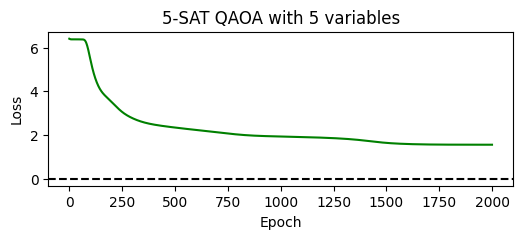

In [25]:
plt.figure(figsize=(6,2))
plt.plot(losses, color = "green")
plt.axhline(y = gs_energy, color = 'black', linestyle = 'dashed')
plt.title(str(k)+'-SAT QAOA with '+str(n_var)+' variables')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [26]:
n_pars = np.arange(1,2*p+1)

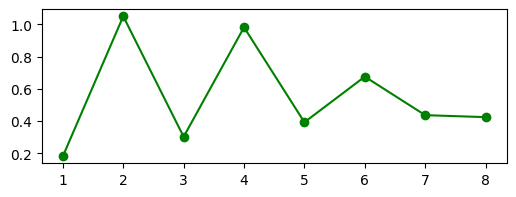

In [27]:
plt.figure(figsize=(6,2))
plt.plot(n_pars, p_list, color = "green", marker = 'o')

In [28]:
def to_dec(x):
    return int("".join(str(i) for i in x), 2) 

In [29]:
sample_circuit = tfq.layers.AddCircuit()(inputs, append=qaoa_circuit)
output = tfq.layers.Sample()(sample_circuit, symbol_names=parameters, symbol_values=params, repetitions = 2048)

quantum_preds = []
data = []
for bits in output.values:
    temp = []
    data.append(to_dec(bits.numpy()))
    for pos, bit in enumerate(bits):
        if bit == 1:
            temp.append(pos)
    quantum_preds.append(temp)

In [30]:
valid_keys

['01010']

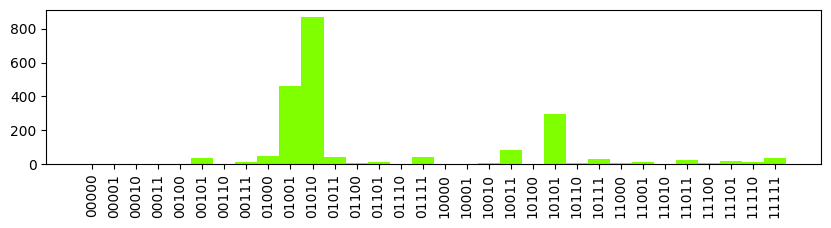

In [31]:
xticks = range(0, 2**nqubits)
xtick_labels = list(map(lambda x: format(x, "0"+str(nqubits)+"b"), xticks))
bins = np.arange(0, 2**nqubits + 1) - 0.5

plt.figure(figsize=(10,2))
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(data, bins=bins, color = "chartreuse", lw=0)
#plt.savefig('hist_custom_sat.pdf')
plt.show()